In [1]:
import glob
import os
import argparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
from matplotlib import patches

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
METADATA = '../metadata/'
EVALDATA = os.path.join(METADATA, 'evaluation/')
model_type = 'swin'
problem='denoise'
attack='none'
pretrained=False
noise_type=1
noise_scale = 0.25
if problem == 'denoise':
    CMAP = sn.cm.rocket_r
    VMIN = 0.08
    VMAX = 0.35
else:
    VMIN = 0.35
    VMAX = 1.0
    CMAP = sn.cm.rocket
noise_scales = {0.25 : 0, 0.5 : 1, 1.0: 2, 2.0 : 3}

In [3]:
def read_robust(model_type=model_type, problem=problem, 
                noise_type=noise_type, noise_scale=noise_scale, attack=attack, pretrained=pretrained, file=None):
    if file is None:
        file = f'robustness_{model_type}_{problem}_noisetype_{noise_type}_noisescale_{noise_scale}_dataclip_True_attack_{attack}_pretrained_{pretrained}.npy'
    return np.load(os.path.join(EVALDATA,  file))

In [4]:
def plot_robustness(robustness, from_file=False, filename=None, 
                    attack=None, to_file=True, only_linear=False,
                    highlight=False, highlight_inf=None, **plot_args):
    if robustness.shape[:1] == 4 or only_linear:
        n = 5
        indices = ['clean', 'gauss+color', '+linear', '+fft', '+hyperbolic',]
    else:
        n = 7
        indices = ['clean', 'gauss+color', '+linear', '+fft', '+hyperbolic', '+bandpass', '+trace']
    df_cm = pd.DataFrame(robustness[:n], index=[i for i in indices],
                         columns=[i for i in [1, 2, 4, 8]])
    plt.figure(figsize=(10, 7))
    plot_args['vmin'] = plot_args.get('vmin', robustness[robustness>0].min())
    sn.heatmap(df_cm, annot=True, cbar=False, **plot_args)
    ax = plt.gca()
    if highlight:
        idx = (noise_scales[noise_scale], noise_type + 1)
        ax.add_patch(
         patches.Rectangle(
             idx,
             1.0,
             1.0,
             edgecolor='red',
             fill=False,
             lw=3
         ) )
    if highlight_inf is not None:
        ax = plt.gca()
        ax.add_patch(
         patches.Rectangle(
             highlight_inf,
             1.0,
             1.0,
             edgecolor='green',
             fill=False,
             lw=3
         ) )
    plt.xlabel('noise to signal')
    plt.ylabel('noise types')
    plt.show()

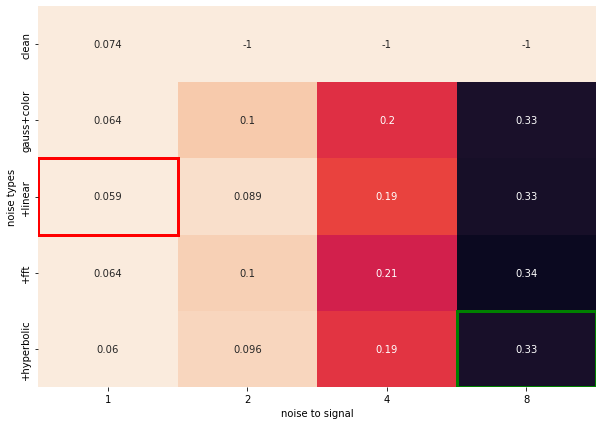

In [5]:
robustness = read_robust()
plot_robustness(robustness, cmap=CMAP, 
                vmin=VMIN, vmax=VMAX, 
                highlight=True, highlight_inf=(3,4), only_linear=True)

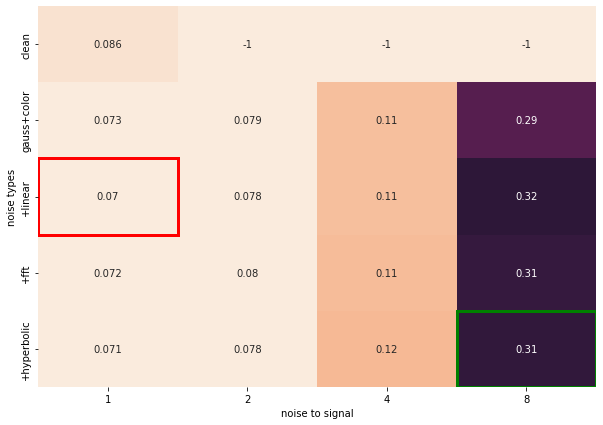

In [6]:
robustness = read_robust(noise_scale=0.5, attack='fgsm')
plot_robustness(robustness, cmap=CMAP, only_linear=True, vmin=VMIN, vmax=VMAX, highlight=True, highlight_inf=(3,4))

In [413]:
def get_robust_dict(model_type, problem, attack='none', pretrained=pretrained, **kwargs):
    output = {}
    for noise_type in [0,1,2,3]:
        for noise_scale in [0.25, 0.5, 1.0, 2.0]:
            try:
                idx = f'{model_type}_{noise_type}_{noise_scale}'
                output[idx] = read_robust(model_type, problem, noise_type, noise_scale, attack, pretrained, **kwargs)
            except FileNotFoundError:
                continue
    return output

restormer_denoise = get_robust_dict('restormer', 'denoise')
swin_denoise = get_robust_dict('swin', 'denoise')
unet_denoise = get_robust_dict('unet', 'denoise')
restormer_fb = get_robust_dict('restormer', 'firstbreak', pretrained=True)
swin_fb_pretrained = get_robust_dict('swin', 'firstbreak', pretrained=True)
swin_fb = get_robust_dict('swin', 'firstbreak', pretrained=False)
unet_fb = get_robust_dict('unet', 'firstbreak')
restormer_denoise_robust = get_robust_dict('restormer', 'denoise', attack='fgsm')
restormer_fb = get_robust_dict('restormer', 'firstbreak')

In [552]:
def get_mean_robust(robust_dict, only_linear=True):
    if only_linear:
        n=5
    else: 
        n=7
    return {key : value[1:n].mean() for key, value in robust_dict.items() }

def top_k(*pargs, k=10, **kwargs):
    output = {}
    for d in pargs:
        output.update(d)
    top_keys = sorted(output, key=lambda x: output[x], **kwargs)[:k]
    return {key : output[key] for key in top_keys}

color_dict = {'restormer' : 'b',
          'unet' : 'g',
          'swin' : 'r'}

rest_mean = get_mean_robust(restormer_denoise)
swin_mean = get_mean_robust(swin_denoise)
unet_mean = get_mean_robust(unet_denoise)
rest_mean_fb = get_mean_robust(restormer_fb)
swin_mean_fb = get_mean_robust(swin_fb)
unet_mean_fb = get_mean_robust(unet_fb)
swin_mean_fb_pretrained = get_mean_robust(swin_fb_pretrained)
top = top_k(rest_mean, swin_mean, unet_mean, k=15)
top_fb = top_k(rest_mean_fb, swin_mean_fb_pretrained, unet_mean_fb, k=15, reverse=True)
colors = list(map(lambda x: color_dict[x.split('_')[0]], top))
colors_fb = list(map(lambda x: color_dict[x.split('_')[0]],top_fb))

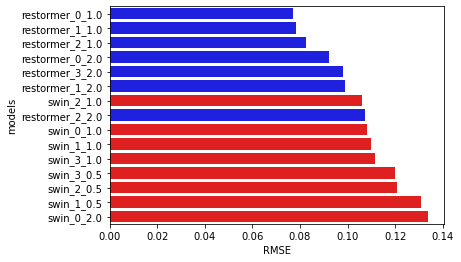

In [553]:
sn.barplot(list(top.values()),list(top.keys()), orient = 'h', palette=colors)
plt.ylabel('models')
plt.xlabel('RMSE')
plt.show()

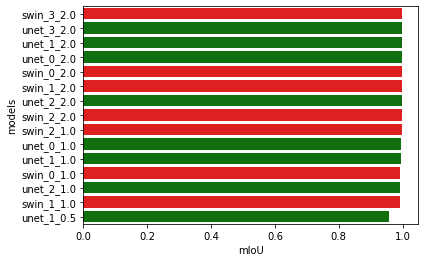

In [554]:
sn.barplot(list(top_fb.values()),list(top_fb.keys()), orient = 'h', palette=colors_fb)
plt.ylabel('models')
plt.xlabel('mIoU')
plt.show()

In [557]:
swin_mean_fb_pretrained, swin_mean_fb

({'swin_0_0.25': 0.8124003405223754,
  'swin_0_0.5': 0.9466827414532741,
  'swin_0_1.0': 0.9922532150265608,
  'swin_0_2.0': 0.9979810461250269,
  'swin_1_0.25': 0.8421135197810596,
  'swin_1_0.5': 0.9346739514883907,
  'swin_1_1.0': 0.9915283750178487,
  'swin_1_2.0': 0.9977494166531303,
  'swin_2_0.25': 0.7994956028132219,
  'swin_2_0.5': 0.9559545834450364,
  'swin_2_1.0': 0.9964556033141689,
  'swin_2_2.0': 0.9971433655375349,
  'swin_3_0.25': 0.8204399353439855,
  'swin_3_1.0': 0.9539289188153222,
  'swin_3_2.0': 0.9984306926199217},
 {'swin_0_0.25': 0.956200885365666,
  'swin_0_0.5': 0.9756017110598842,
  'swin_0_1.0': 0.9941179053972817,
  'swin_0_2.0': 0.9891665311429969,
  'swin_1_0.25': 0.9640019479446944,
  'swin_1_0.5': 0.9809233031232438,
  'swin_1_1.0': 0.9935034179407112,
  'swin_1_2.0': 0.9862942553861935,
  'swin_2_0.25': 0.9505368334513191,
  'swin_2_0.5': 0.9794833977363312,
  'swin_2_1.0': 0.9915765794457065,
  'swin_2_2.0': 0.9850217315051368,
  'swin_3_0.25': 0.87

In [581]:
pretrained_keys = ['pretrained_' + key for key in swin_mean_fb_pretrained]
pretrained_values = list(swin_mean_fb_pretrained.values())
keys = list(swin_mean_fb.keys())
values = list(swin_mean_fb.values())
keys_ = pretrained_keys + keys
values_ = pretrained_values + values
pretrained_vs = {key : value for key, value in zip(keys_, values_)}

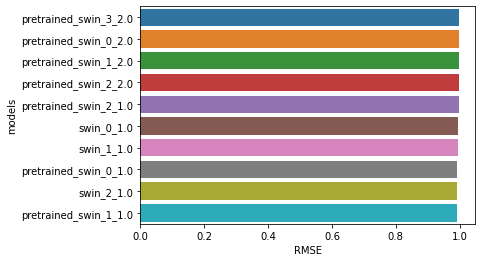

In [588]:
top_pretrained = top_k(pretrained_vs, reverse=True, k=10)
sn.barplot(list(top_pretrained.values()),list(top_pretrained.keys()), orient = 'h')
plt.ylabel('models')
plt.xlabel('RMSE')
plt.show()

In [580]:
pretrained_vs

{'swin_0_0.25': 0.8124003405223754,
 'swin_0_0.5': 0.9466827414532741,
 'swin_0_1.0': 0.9922532150265608,
 'swin_0_2.0': 0.9979810461250269,
 'swin_1_0.25': 0.8421135197810596,
 'swin_1_0.5': 0.9346739514883907,
 'swin_1_1.0': 0.9915283750178487,
 'swin_1_2.0': 0.9977494166531303,
 'swin_2_0.25': 0.7994956028132219,
 'swin_2_0.5': 0.9559545834450364,
 'swin_2_1.0': 0.9964556033141689,
 'swin_2_2.0': 0.9971433655375349,
 'swin_3_0.25': 0.8204399353439855,
 'swin_3_0.5': 0.9539289188153222,
 'swin_3_1.0': 0.9984306926199217,
 'swin_3_2.0': 0.956200885365666}

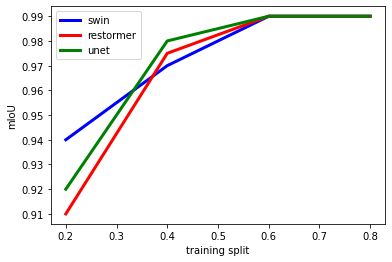

In [27]:
unet = np.array([0.92, 0.98, 0.99, 0.99])
swin = np.array([0.94,0.97,0.99,0.99])
restormer = np.array([0.91,0.975,0.99,0.99])
split = [0.2, 0.4, 0.6, 0.8]
plt.figure(figsize=[6,4])
plt.plot(split, swin, 'b', linewidth=3, label='swin')
plt.plot(split, restormer, 'r', linewidth=3, label='restormer')
plt.plot(split, unet, 'g', linewidth=3, label='unet')
plt.ylabel('mIoU')
plt.xlabel('training split')
plt.legend()
plt.show()